# Numbers and plots for presentation

In [1]:
from scipy import stats
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# Extractions
df = pd.read_csv('../data/UCI_Credit_Card.csv')
display(df.head())

X_train = pd.read_csv('../data/X_train.csv')
display(X_train.head())

y_train = pd.read_csv('../data/y_train.csv')
display(y_train.head())

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,dummy_recent_payment_delay,dummy_20s,dummy_30s,dummy_40s,dummy_50s,dummy_60s,dummy_over_70s,debt_capacity,limit_usage,dummy_overlimit_usage
0,265,80000,2,1,2,37,-1,-1,-1,-1,...,0,0,1,0,0,0,0,1.000000,0.073029,0
1,11595,190000,2,2,1,33,0,0,0,-2,...,0,0,1,0,0,0,0,0.053463,0.214008,0
2,27780,230000,2,1,2,24,-1,0,0,0,...,0,1,0,0,0,0,0,0.767018,0.019314,0
3,381,130000,2,2,2,29,0,0,0,0,...,0,1,0,0,0,0,0,0.038106,0.605614,0
4,25600,20000,2,3,2,45,-1,-1,-1,-1,...,0,0,0,1,0,0,0,0.843567,0.022000,0


,default.payment.next.month
0,0
1,0
2,0
3,0
4,0


In [3]:
# How much credit are in transaction in Oct/2005?
amt = df['BILL_AMT1'].sum()

# Converting to brazillian real.
twd_to_real = 0.16
amt * twd_to_real

245871988.32

In [4]:
# How much credit is delayed?
amt_delay = df.loc[df['default.payment.next.month'] == 1, 'BILL_AMT1'].sum()
amt_delay * twd_to_real

51505088.160000004

In [5]:
# What is the percentage of low term delay.
amt_delay_low = df.loc[(df['default.payment.next.month'] == 1) & (df['PAY_0'] <= 3), 'BILL_AMT1'].sum()
amt_delay_low / amt_delay

0.9713624969358755

In [6]:
# What is the percentage of high term delay.
amt_delay_high = df.loc[(df['default.payment.next.month'] == 1) & (df['PAY_0'] >= 4), 'BILL_AMT1'].sum()
amt_delay_high / amt_delay

0.02863750306412445

In [7]:
# How many features were created?
len(set(X_train.columns) - set(df.columns))

15

In [8]:
# How much 1 p.p. of payment delay cost?

# a. What delay percentage?
perc_target = len(df.loc[df['default.payment.next.month'] == 1]) / len(df)
print(perc_target)

# b. Calculate 1 p.p. cost.
cost_1pp = amt_delay / (perc_target * 100)
print(cost_1pp * twd_to_real)

0.2212
2328439.790235081


In [9]:
# Feature dummy_recent_payment_delay have higher probability of delay?
df_train = pd.concat([X_train, y_train], axis=1)

df_recent = df_train.groupby(['dummy_recent_payment_delay', 'default.payment.next.month']).size()
df_recent = df_recent / df_recent.groupby('dummy_recent_payment_delay').transform('sum')

df_recent

dummy_recent_payment_delay  default.payment.next.month
0                           0                             0.820016
                            1                             0.179984
1                           0                             0.364138
                            1                             0.635862
dtype: float64

In [10]:
# Create a circular barplot with correlation (part 1)

def num_var_correlation(df, num_var):
    # It basically compare variance intragroups vs variance of whole sample.
    target = 'default.payment.next.month'
    inner_var = 0
    for cat in df[target].unique():
        inner_var = inner_var + math.pow(df.loc[df[target] == cat, num_var].mean() - df[num_var].mean(), 2) * len(df.loc[df[target] == cat])
    
    outer_var = np.sum((df[num_var] - df[num_var].mean()) ** 2)
    return  math.sqrt(inner_var / outer_var)
    

def cat_var_correlation(df, cat_var):
    df = pd.pivot_table(
        df,
        index=cat_var,
        columns='default.payment.next.month',
        values='ID',
        aggfunc='count'
    ).reset_index()

    f_obs = np.array(df[1])
    avg_target = df[1].sum() / df[[0, 1]].sum().sum()
    f_exp = np.array((df[[0, 1]].sum(axis=1) * avg_target))#.round(0).astype(int))
    
    st, _ = stats.chisquare(f_obs, f_exp)
    v = (st / np.sum(f_obs)) ** 0.5
    return v

df_plot = pd.DataFrame({
    'variable': df_train.drop(columns='default.payment.next.month').columns,
    'type': None,
    'correlation': None
})

# Assign datatype.
df_plot.loc[df_plot['variable'].str.contains('AMT'), 'type'] = 'numeric'
df_plot.loc[df_plot['variable'] == 'AGE', 'type'] = 'numeric'
df_plot.loc[df_plot['variable'] == 'ID', 'type'] = 'numeric'
df_plot.loc[df_plot['variable'] == 'LIMIT_BAL', 'type'] = 'numeric'
df_plot.loc[df_plot['variable'] == 'debt_capacity', 'type'] = 'numeric'
df_plot.loc[df_plot['variable'] == 'limit_usage', 'type'] = 'numeric'

# Assign group.
df_plot['group'] = np.select(
    [
        df_plot['variable'].str.contains('BILL_AMT'),
        df_plot['variable'].str.contains('PAY_AMT'),
        df_plot['variable'].isin(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'dummy_20s', 'dummy_30s', 'dummy_40s', 'dummy_50s', 'dummy_60s', 'dummy_over_70s']),
        df_plot['variable'].str.contains('|'.join(['PAY_', 'tardiness', 'delay']))
    ],
    [
        'Billing ammount',
        'Paying ammount',
        'Demographic',
        'Payment status'
    ], 'Credit limit'
)
#display(df_plot['group'].value_counts())

# Calculating correlation
# if numerical_feature then correlation ratio
# if categorical feature then cramér's v
df_plot['correlation'] = [num_var_correlation(df_train, i) if df_plot.loc[df_plot['variable'] == i, 'type'].values[0] == 'numeric' else cat_var_correlation(df_train, i) for i in list(df_plot['variable'])]
df_plot['correlation'] = (df_plot['correlation'] * 100).clip(lower=2)
df_plot = df_plot.sort_values(['group', 'variable'])
df_plot

,variable,type,correlation,group
12,BILL_AMT1,numeric,2.001120,Billing ammount
13,BILL_AMT2,numeric,2.000000,Billing ammount
14,BILL_AMT3,numeric,2.000000,Billing ammount
15,BILL_AMT4,numeric,2.000000,Billing ammount
16,BILL_AMT5,numeric,2.000000,Billing ammount
17,BILL_AMT6,numeric,2.000000,Billing ammount
1,LIMIT_BAL,numeric,14.905740,Credit limit
36,debt_capacity,numeric,10.500626,Credit limit
24,dummy_low_credit_usage,None,4.240392,Credit limit
38,dummy_overlimit_usage,None,8.334563,Credit limit


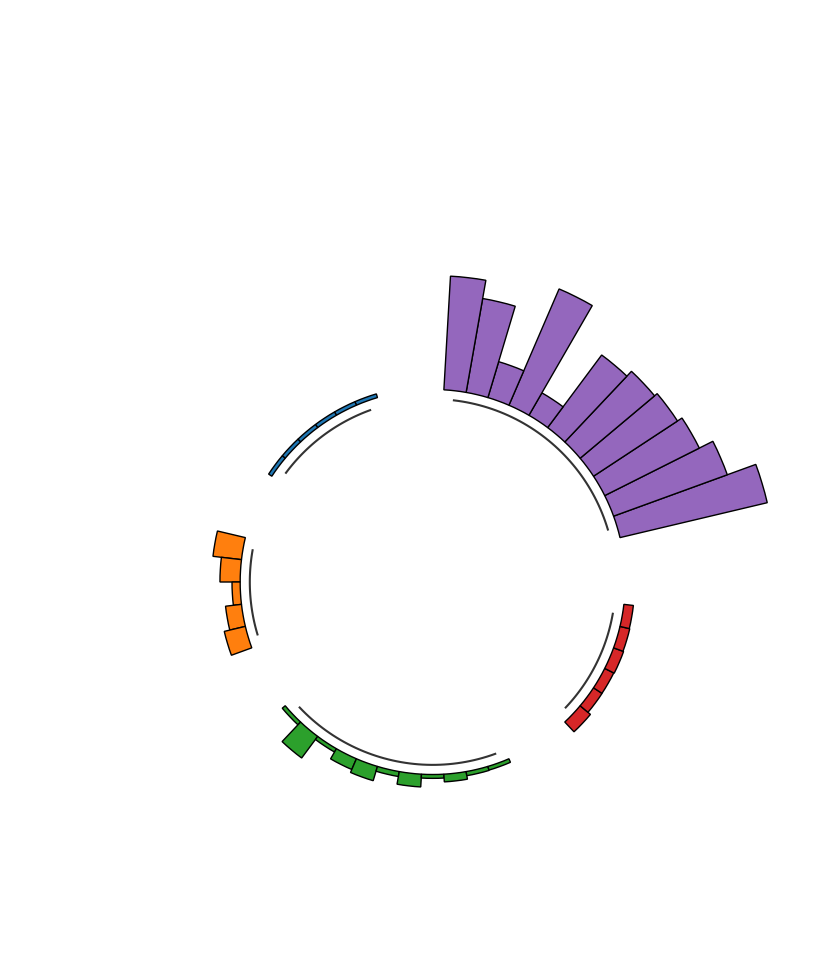

In [11]:
# Creating the plot (part 2)
# Source: https://python-graph-gallery.com/circular-barplot-basic/
VALUES = df_plot['correlation'].values
LABELS = df_plot['variable'].values
GROUP = df_plot['group'].values

PAD = 3
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)

GROUPS_SIZE = [len(i[1]) for i in df_plot.groupby("group")]

offset = 0
IDXS = []
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
OFFSET = np.pi / 2
ax.set_theta_offset(OFFSET)
ax.set_ylim(-100, 100)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

GROUPS_SIZE = [len(i[1]) for i in df_plot.groupby("group")]
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

ax.bar(
    ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, 
    edgecolor="black", linewidth=1
)

def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment


def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 4
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor",
            fontsize=12,
            #fontweight='bold',
            color='white'
        ) 


add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

# Extra customization below here --------------------

# This iterates over the sizes of the groups adding reference
# lines and annotations.

offset = 0 
for group, size in zip(list(df_plot['group'].unique()), GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    #ax.text(
    #    np.mean(x1), -20, group, color="#333333", fontsize=8, 
    #    fontweight="bold", ha="center", va="center"
    #)
    
    # Add reference lines at 20, 40, 60, and 80
    #x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    #ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
    #ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
    #ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)
    #ax.plot(x2, [80] * 50, color="#bebebe", lw=0.8)
    #ax.plot(x2, [100] * 50, color="#bebebe", lw=0.8)
    
    offset += size + PAD
    plt.savefig('circular-barplot.png', transparent=True)

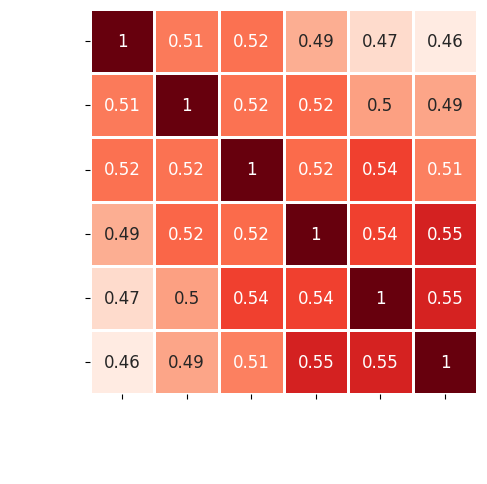

In [73]:
# Correlation heatmap with PAY_AMT.
df_pay_amt = df_train[[i for i in df_train.columns if 'PAY_AMT' in i]].corr(method='spearman')
plt.figure(figsize=(5,5))
f = sns.heatmap(df_pay_amt, linewidth=1, vmin=0.45, vmax=0.59, cmap='Reds', annot=True, annot_kws={'size': 12}, cbar=False)
#plt.rcParams['text.color'] = 'red'

#f.set_title("Scatter Plot", color='white')
f.set_xticklabels(f.get_xticklabels(), color='white')
f.set_yticklabels(f.get_yticklabels(), color='white')

#plt.show()
plt.savefig('heatmap-pay-amt.png', transparent=True)

,Name,Value
0,graduate_school,0.096310
1,university,0.068427
2,high school,0.060801
3,others,0.047655
4,unknown,0.068854


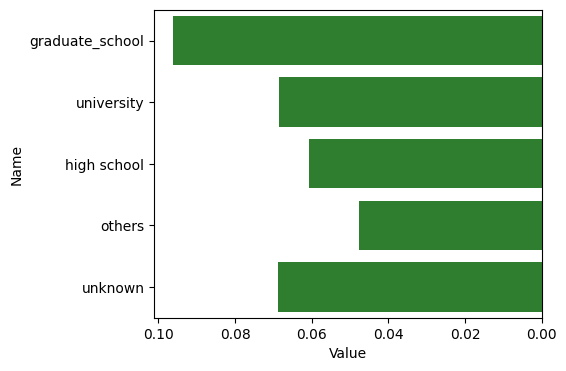

In [89]:
# Calculate cramer v for every education category.
list_educ = ['graduate_school', 'university', 'high school', 'others', 'unknown']
list_corr = []
for i in range(1, 6):
    df_temp = df.copy(deep=True)
    df_temp['temp'] = np.where(df_temp['EDUCATION'] == i, 1, 0)
    c = cat_var_correlation(df_temp, 'temp')
    #print(f'Education {i} have correlation of {round(c,3)}')
    list_corr.append(c)

df_plot = pd.DataFrame({'Name': list_educ, 'Value': list_corr})
display(df_plot)

plt.figure(figsize=(5, 4))
f = sns.barplot(df_plot, x='Value', y='Name', color='forestgreen')
f.invert_xaxis()
#f.spines['top'].set_color('white')
#f.spines['bottom'].set_color('white')
#f.spines['left'].set_color('white')
#f.spines['right'].set_color('white')  
#f.set_xlabel('')
#f.set_ylabel('')
#f.xaxis.label.set_color('white')        #setting up X-axis label color to yellow
#f.yaxis.label.set_color('white')          #setting up Y-axis label color to blue
#f.tick_params(axis='x', colors='white')    #setting up X-axis tick color to red
#f.tick_params(axis='y', colors='white')
plt.savefig('barplot-education.png', transparent=True, bbox_inches='tight')

In [38]:
df_train['EDUCATION'].value_counts()
#df_train.loc[df_train['EDUCATION'] == 6, 'EDUCATION'] = 5

EDUCATION
2    11237
1     8457
3     3938
5      259
4       97
Name: count, dtype: int64